In [1]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from gmphd_copy import mtt_phd
from utils import *

In [2]:
# Measurement parameters
dim = 2
dt = 1.0
num_steps = 50

birth_prob = 0.2
death_prob = 0.005

det_prob = 0.9
clutter_rate = 3

pos_bounds = (-30, 30)
vel_bounds = (-1, 1)

area = (-100, 100)

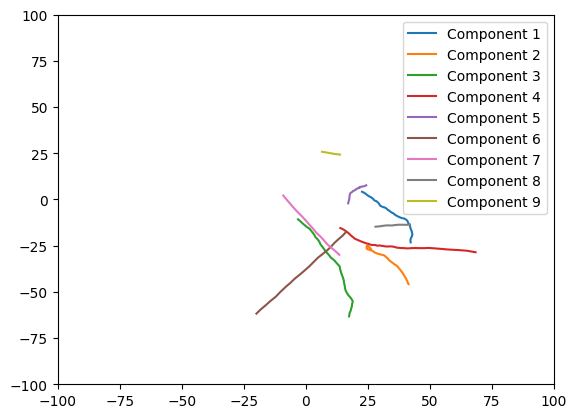

In [3]:
# generate ground truth data
F = create_state_matrix(dt, dim)
Q = np.identity(F.shape[0]) * 0.01

truths = simulate_motion(F, Q, num_steps=num_steps, birth_prob=birth_prob, death_prob=death_prob, pos_bounds=pos_bounds, vel_bounds=vel_bounds)
for i, state in truths.items():
    pos = np.array([s[:2] if s is not None else [np.nan, np.nan] for s in state])
    plt.plot(*pos[:,:2].T, label=f'Component {i + 1}')
    plt.xlim(*area)
    plt.ylim(*area)
plt.legend()

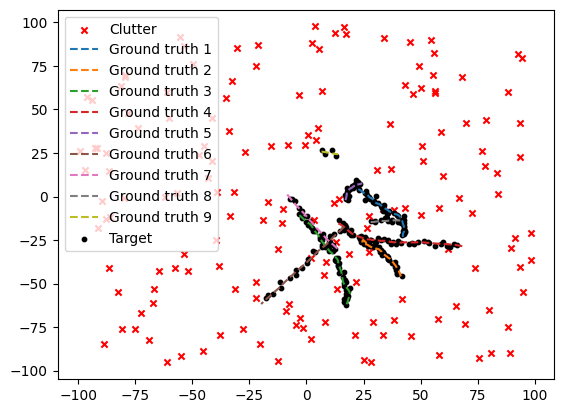

In [4]:
# generate measurements
H = create_measurement_matrix(dim)
R = np.identity(H.shape[0]) * 0.75

all_measurements = simulate_measurement(truths, H, R, num_steps=num_steps, det_prob=det_prob, clutter_rate=clutter_rate, area=area)

component_ids = sorted({i for measurements in all_measurements.values() for i, _ in measurements if i is not None})

for measurements in all_measurements.values():
    for i, measurement in measurements:
        if i is None:
            plt.scatter(measurement[0], measurement[1], c='red', marker='x', label='Clutter', s=20)
        else:
            plt.scatter(measurement[0], measurement[1], color='black', label=f'Target', s=10)
    
for i, state in truths.items():
    pos = np.array([s[:2] if s is not None else [np.nan, np.nan] for s in state])
    # print(pos)
    plt.plot(*pos[:,:2].T, label=f'Ground truth {i + 1}', linestyle='dashed')

# ignore duplicates
handles, labels = plt.gca().get_legend_handles_labels()
unique = dict(zip(labels, handles))
order = np.argsort(list(unique.keys()))
plt.legend([list(unique.values())[i] for i in order], [list(unique.keys())[i] for i in order])

In [5]:
print("F")
print(F)
print("Q")
print(Q)
print("H")
print(H)
print("R")
print(R)

F
[[1. 0. 1. 0.]
 [0. 1. 0. 1.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]
Q
[[0.01 0.   0.   0.  ]
 [0.   0.01 0.   0.  ]
 [0.   0.   0.01 0.  ]
 [0.   0.   0.   0.01]]
H
[[1. 0. 0. 0.]
 [0. 1. 0. 0.]]
R
[[0.75 0.  ]
 [0.   0.75]]


In [6]:
# get initial truths
init_truths = []
for states in truths.values():
    if states[0] is not None:
        init_truths.append(states[0])
    
init_truths = np.array(init_truths)

num_components = len(init_truths)

# assume each component has the same weight
component_weight = 1e-3

# the variance of pos and vel
pos_var = 10
vel_var = 5

# each component assumed to start at a random (x, y) ~ U([-50, 50] x [-50, 50])
start_bounds = (-50, 50)

w = [component_weight] * num_components
# m = init_truths.copy()
m = []
for i in range(num_components):
    # m.append(np.random.uniform(start_bounds[0], start_bounds[1], size=(dim,)))
    m.append(np.array([
            *np.random.uniform(*start_bounds, 2),
            # initial velocity (dx, dy) ~ U(-2, 2) x U(-2, 2)
            0, 
            0
    ]))
m = np.array(m)
P = np.array([np.diag([pos_var, pos_var, vel_var, vel_var])**2 for _ in range(num_components)])

In [7]:
print("Initial weights:")
print(w)
print("Initial means:")
print(m)
print("Initial covariances:")
print(P)

Initial weights:
[0.001, 0.001, 0.001]
Initial means:
[[  0.71876629  36.75324172   0.           0.        ]
 [-24.33846292 -18.15560124   0.           0.        ]
 [-16.89636496  17.3214239    0.           0.        ]]
Initial covariances:
[[[100   0   0   0]
  [  0 100   0   0]
  [  0   0  25   0]
  [  0   0   0  25]]

 [[100   0   0   0]
  [  0 100   0   0]
  [  0   0  25   0]
  [  0   0   0  25]]

 [[100   0   0   0]
  [  0 100   0   0]
  [  0   0  25   0]
  [  0   0   0  25]]]


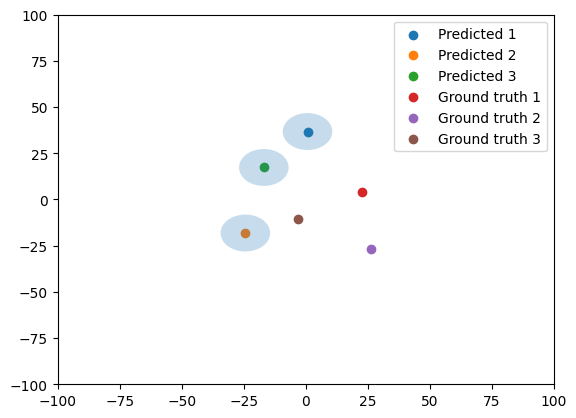

In [8]:
fig, ax = plt.subplots()
for i in range(len(w)):
    pos = m[i][:2]
    cov = P[i][:2, :2]
    eigvals, eigvecs = np.linalg.eig(cov)
    a = eigvals.argsort()[::-1]
    eigvals = eigvals[a]
    unc = patches.Ellipse(pos, 2 * np.sqrt(eigvals[0]), 2 * np.sqrt(eigvals[1]), angle=0, alpha=0.25)
    ax.scatter(pos[0], pos[1], label=f'Predicted {i + 1}')
    ax.add_patch(unc)
    ax.set_xlim(*area)
    ax.set_ylim(*area)

for i in range(len(init_truths)):
    pos = init_truths[i][:2]
    ax.scatter(*pos, label=f'Ground truth {i + 1}')
plt.legend()

In [9]:
# print(all_measurements)
# all_measurements.pop(0)
# print(all_measurements)

In [16]:
# initialize the filter
filter = mtt_phd(
    weights=w,
    position=m,
    p_cov=P,
    num_components=num_components,
    measurement=all_measurements,
    state_transition_matrix=F,
    process_noise_matrix=Q,
    measurement_matrix=H,
    measurement_noise=R,
    num_steps=len(all_measurements)-1,
    detection_probability=det_prob,
    clutter_intensity=clutter_rate/(area[1] - area[0])**2,
    merging_threshold = 2.0,
    truncation_threshold = 1e-8, # make sure squared
    threshold_weight= 0.25,
    new_birth_weight=0.25,
)

In [17]:
history = filter.run()
history

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


[[],
 [[26.130811587060045,
   -26.212474835838368,
   0.6066374660039902,
   0.26305618589102386],
  [23.11310413408606,
   3.913122605754518,
   0.4835453577548002,
   0.4315983258636572],
  [14.394544724303016,
   -1.2601100800907998,
   -2.3364391923666767,
   -2.313911413079353]],
 [],
 [[16.35111466869515,
   -17.434253465961547,
   -0.2776506915044721,
   -0.4513756991284739],
  [12.763290578441069,
   -26.222823257304405,
   -2.5198248195375825,
   -2.7970830481340383]],
 [],
 [],
 [],
 [],
 [[24.40197090601068,
   -25.628787091064968,
   -0.15426875829906425,
   -0.0794241748778139],
  [16.590781115516283,
   -19.420236906337728,
   -0.21056520883569244,
   -0.7886198583794679],
  [3.573229740186308,
   -19.240398268364483,
   0.6488141565697324,
   -1.0926603616621031],
  [25.816150072315672,
   -1.921738173236566,
   -1.4498543214117718,
   -1.451513261619587]],
 [[24.803429193763012,
   -25.263252594008147,
   0.18608927136267936,
   0.19651707028250118],
  [3.3061711450797

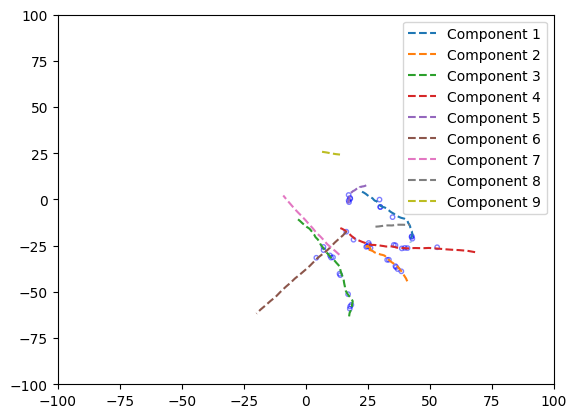

In [18]:
pos = []
for state in history:
    if len(state) > 0:
        pos.append(state[0][:2])
pos = np.array(pos)
plt.scatter(*pos.T, facecolors='none', edgecolors='blue', alpha=0.5, s=10)
plt.xlim(*area)
plt.ylim(*area)

for i, state in truths.items():
    pos = np.array([s[:2] if s is not None else [np.nan, np.nan] for s in state])
    plt.plot(*pos[:,:2].T, linestyle='dashed', label=f'Component {i + 1}')
plt.legend()